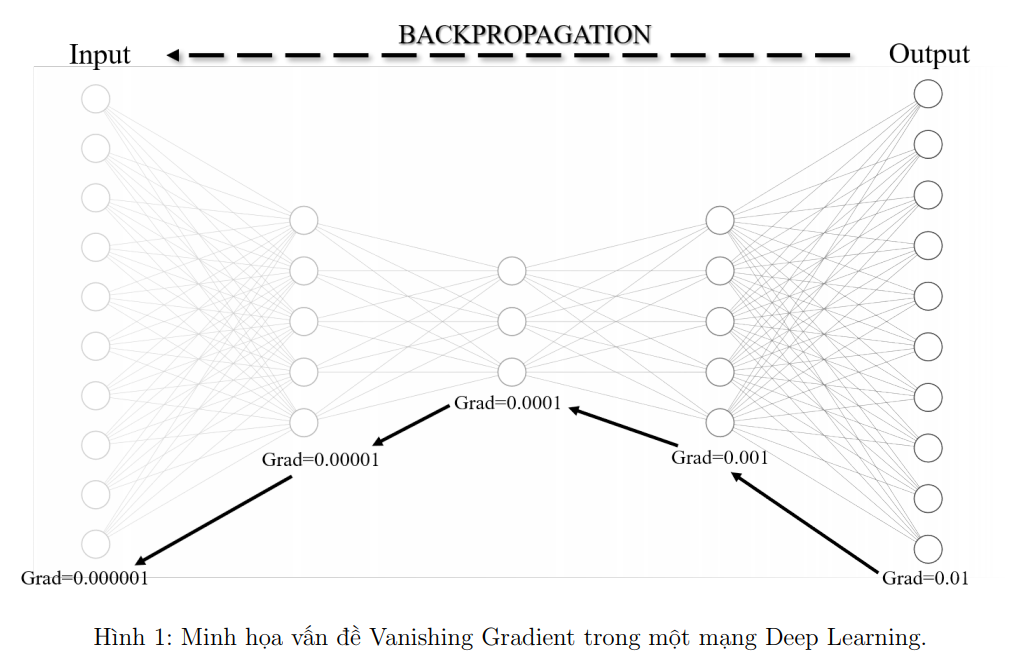

# **Nguyên nhân chính của hiện tượng Vanishing Gradient**  

Vanishing Gradient xuất phát từ quy tắc chuỗi (chain rule) trong quá trình lan truyền ngược. Gradient tại các layer gần input layer giảm dần theo tích gradient qua các lớp trước đó, dẫn đến gần như bằng 0 trong các mạng sâu. Đây là một trong những thách thức lớn nhất trong huấn luyện một deep neural network, đòi hỏi các phương pháp xử lý hiệu quả để khắc phục.

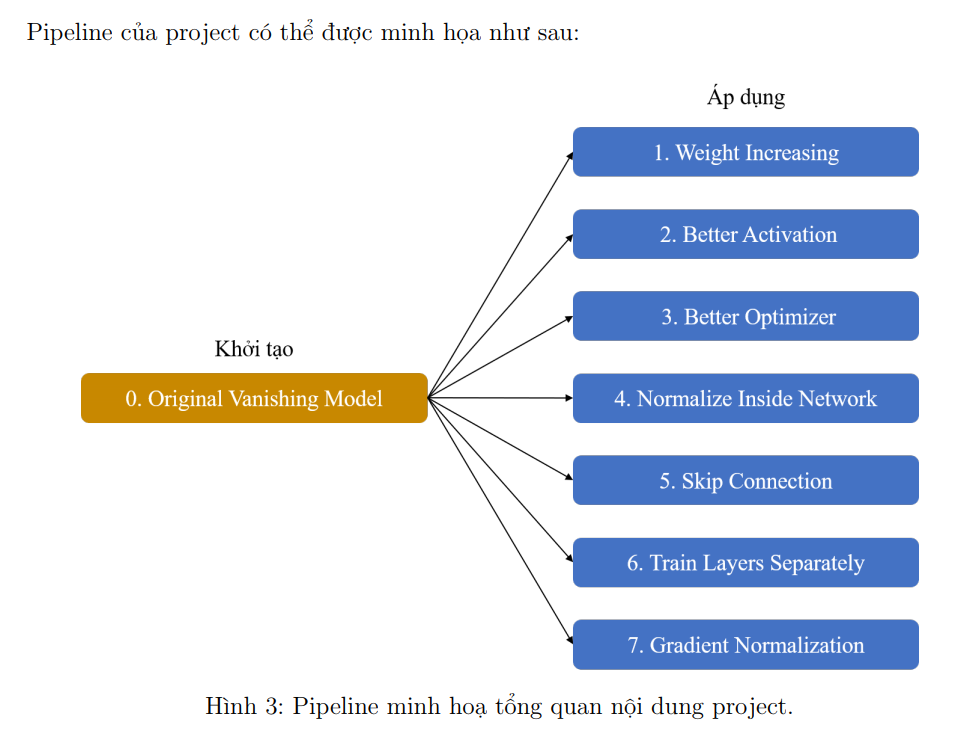

# **MLP baseline model trên Fashion MNIST**

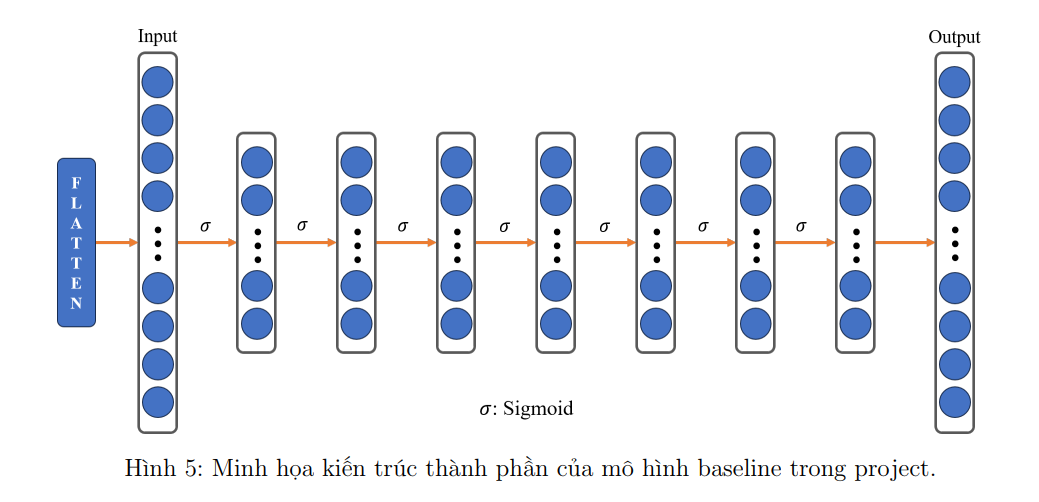

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.77MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.67MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/100] Train Loss: 2.3042, Train Acc: 9.96%, Val Loss: 2.3062, Val Acc: 8.95%
Epoch [2/100] Train Loss: 2.3038, Train Acc: 9.83%, Val Loss: 2.3041, Val Acc: 8.95%
Epoch [3/100] Train Loss: 2.3039, Train Acc: 9.62%, Val Loss: 2.3043, Val Acc: 10.22%
Epoch [4/100] Train Loss: 2.3039, Train Acc: 10.07%, Val Loss: 2.3036, Val Acc: 10.22%
Epoch [5/100] Train Loss: 2.3038, Train Acc: 10.09%, Val Loss: 2.3042, Val Acc: 10.12%
Epoch [6/100] Train Loss: 2.3039, Train Acc: 9.89%, Val Loss: 2.3045, Val Acc: 10.00%
Epoch [7/100] Train Loss: 2.3038, Train Acc: 10.06%, Val Loss: 2.3038, Val Acc: 9.37%
Epoch [8/100] Train Loss: 2.3036, Train Acc: 9.93%, Val Loss: 2.3030, Val Acc: 10.18%
Epoch [9/100] Train Loss: 2.3038, Train Acc: 10.00%, Val Loss: 2.3035, Val Acc: 10.20%
Epoch [10/100] Train Loss: 2.3034, Train Acc: 10.14%, Val Loss: 2.3025, Val Acc: 10.97%
Epoch [11/100] Train Loss: 2.3038, Train Acc: 9.

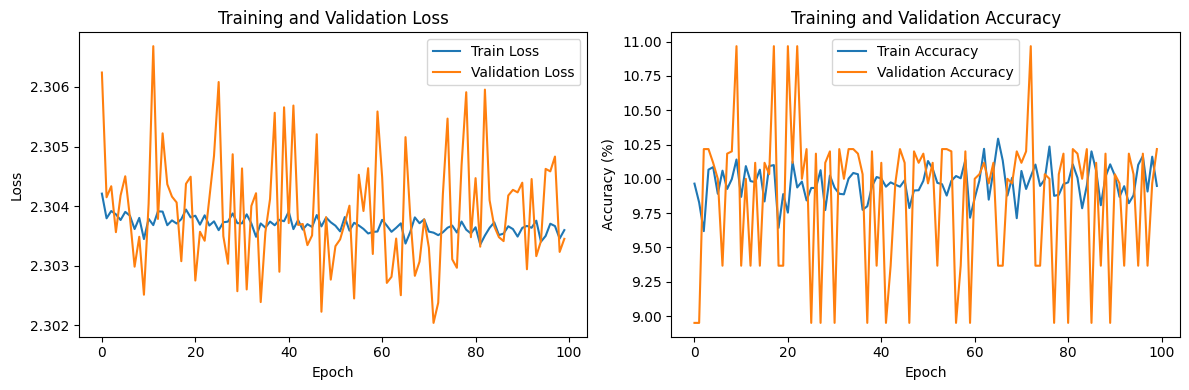

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

# 1. Thiết lập môi trường và seed
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# 2. Tải và chuẩn bị dữ liệu
train_dataset = FashionMNIST('./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

# 3. Chia tập train/validation
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# 4. Tạo DataLoader
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Định nghĩa mô hình MLP
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

# 6. Khởi tạo mô hình và định nghĩa loss, optimizer
input_dims = 784  # 28x28 pixels
hidden_dims = 128
output_dims = 10  # 10 classes
lr = 1e-2

model = MLP(input_dims=input_dims,
           hidden_dims=hidden_dims,
           output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 7. Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

# 8. Huấn luyện mô hình
epochs = 100
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs)

# 9. Vẽ đồ thị kết quả
def plot_results(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')

    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

plot_results(train_losses, val_losses, train_accs, val_accs)

**1. Weight Increasing:** Kỹ thuật này tập trung vào việc khởi tạo trọng số ban đầu với các giá trị lớn hơn nhằm tăng giá trị gradient trong các bước lan truyền ngược

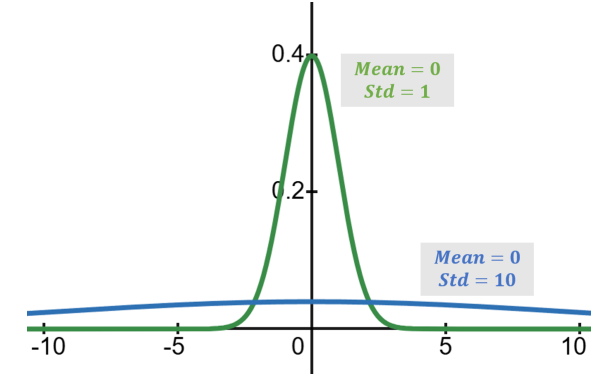

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.25MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Training with weight std = 1.0
Epoch [1/100] Train Loss: 1.7352, Train Acc: 45.05%, Val Loss: 1.2657, Val Acc: 55.35%
Epoch [2/100] Train Loss: 1.1214, Train Acc: 59.65%, Val Loss: 1.0754, Val Acc: 61.38%
Epoch [3/100] Train Loss: 0.9869, Train Acc: 64.42%, Val Loss: 0.9772, Val Acc: 65.23%
Epoch [4/100] Train Loss: 0.9110, Train Acc: 67.07%, Val Loss: 0.9148, Val Acc: 67.25%
Epoch [5/100] Train Loss: 0.8596, Train Acc: 68.89%, Val Loss: 0.8746, Val Acc: 68.53%
Epoch [6/100] Train Loss: 0.8220, Train Acc: 70.14%, Val Loss: 0.8433, Val Acc: 69.92%
Epoch [7/100] Train Loss: 0.7914, Train Acc: 71.34%, Val Loss: 0.8217, Val Acc: 70.80%
Epoch [8/100] Train Loss: 0.7676, Train Acc: 72.13%, Val Loss: 0.8045, Val Acc: 71.28%
Epoch [9/100] Train Loss: 0.7472, Train Acc: 72.82%, Val Loss: 0.7872, Val Acc: 71.68%
Epoch [10/100] Train Loss: 0.7301, Train Acc: 73.39%, Val Loss: 0.7740, Val Acc: 72.47%
Epoch [1

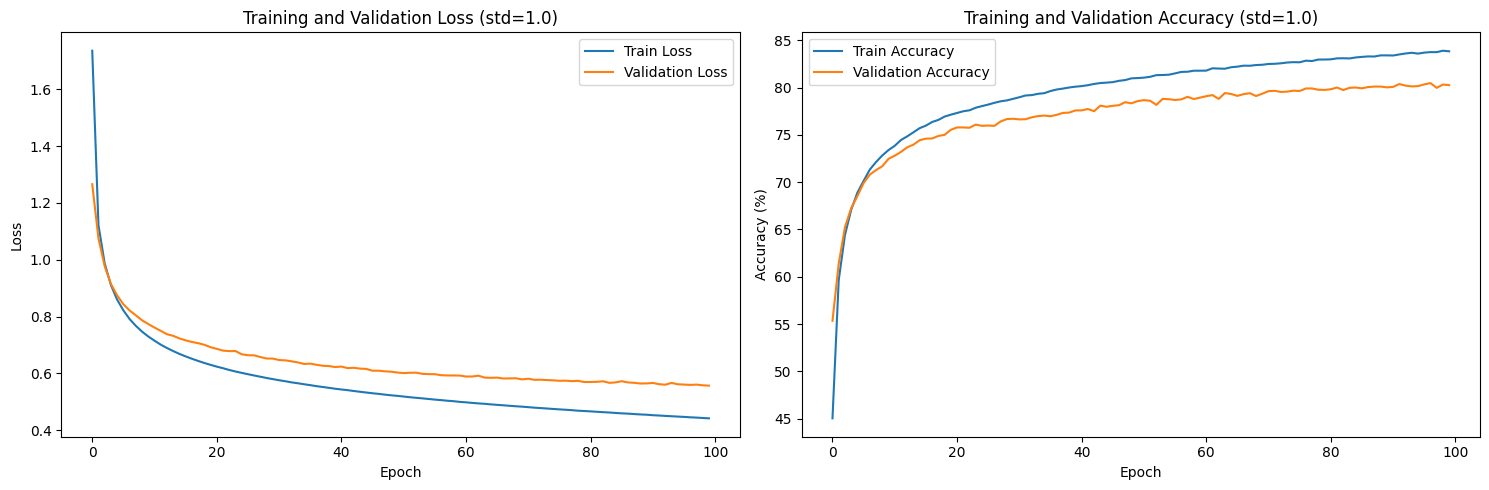


Training with weight std = 10.0
Epoch [1/100] Train Loss: 45.7593, Train Acc: 10.89%, Val Loss: 11.9009, Val Acc: 9.92%
Epoch [2/100] Train Loss: 6.7931, Train Acc: 10.38%, Val Loss: 3.9183, Val Acc: 8.92%
Epoch [3/100] Train Loss: 3.4786, Train Acc: 11.43%, Val Loss: 3.2704, Val Acc: 14.52%
Epoch [4/100] Train Loss: 2.8740, Train Acc: 11.04%, Val Loss: 2.5792, Val Acc: 10.47%
Epoch [5/100] Train Loss: 2.6596, Train Acc: 10.61%, Val Loss: 2.7988, Val Acc: 8.63%
Epoch [6/100] Train Loss: 2.9866, Train Acc: 11.13%, Val Loss: 4.0486, Val Acc: 13.22%
Epoch [7/100] Train Loss: 2.5794, Train Acc: 10.96%, Val Loss: 2.5511, Val Acc: 10.95%
Epoch [8/100] Train Loss: 2.4783, Train Acc: 11.46%, Val Loss: 2.4730, Val Acc: 12.55%
Epoch [9/100] Train Loss: 2.4346, Train Acc: 12.34%, Val Loss: 2.4071, Val Acc: 12.43%
Epoch [10/100] Train Loss: 2.4218, Train Acc: 12.64%, Val Loss: 2.4207, Val Acc: 14.25%
Epoch [11/100] Train Loss: 2.4004, Train Acc: 11.96%, Val Loss: 2.3911, Val Acc: 12.63%
Epoch [12

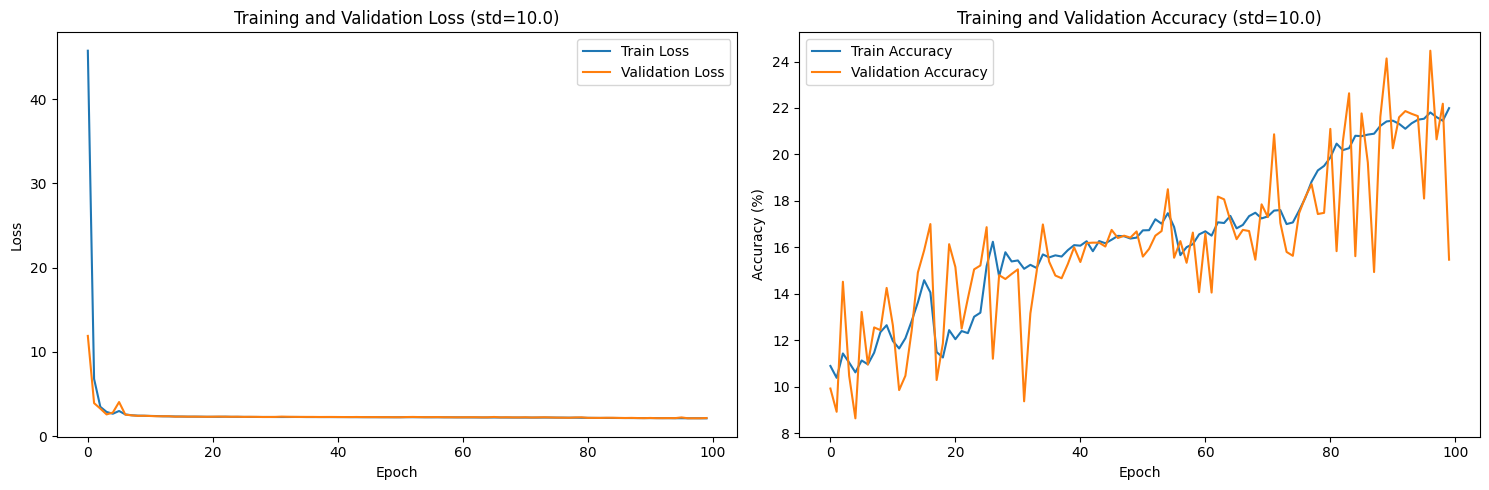


Kết quả so sánh:
--------------------------------------------------

Std = 1.0:
Train Loss: 0.4423
Val Loss: 0.5573
Train Acc: 83.83%
Val Acc: 80.25%

Std = 10.0:
Train Loss: 2.1133
Val Loss: 2.1509
Train Acc: 21.99%
Val Acc: 15.47%


In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

# 1. Thiết lập môi trường và seed
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# 2. Định nghĩa mô hình MLP với khởi tạo trọng số tùy chỉnh
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, weight_std=0.05):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        ################# 1. Weight Increasing ################
        # Khởi tạo trọng số với độ lệch chuẩn được chỉ định
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=weight_std)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

# 3. Hàm huấn luyện và đánh giá
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

# 4. Hàm vẽ kết quả
def plot_results(train_losses, val_losses, train_accs, val_accs, title_suffix=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title(f'Training and Validation Loss {title_suffix}')

    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title(f'Training and Validation Accuracy {title_suffix}')

    plt.tight_layout()
    plt.show()

# 5. Thử nghiệm với std=1.0
def train_with_std(std_value):
    print(f"\nTraining with weight std = {std_value}")

    # Khởi tạo model
    model = MLP(input_dims=784,
                hidden_dims=128,
                output_dims=10,
                weight_std=std_value).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=1e-2)

    # Train model
    train_losses, train_accs, val_losses, val_accs = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=100)

    # Vẽ kết quả
    plot_results(train_losses, val_losses, train_accs, val_accs,
                title_suffix=f"(std={std_value})")

    return model, train_losses[-1], val_losses[-1], train_accs[-1], val_accs[-1]

# 6. Load dữ liệu
train_dataset = FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', train=False, download=True,
                           transform=transforms.ToTensor())

# Chia tập train/validation
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Tạo DataLoader
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 7. Thử nghiệm với cả hai giá trị std
results = {}
for std in [1.0, 10.0]:
    model, train_loss, val_loss, train_acc, val_acc = train_with_std(std)
    results[std] = {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

# 8. In kết quả so sánh
print("\nKết quả so sánh:")
print("-" * 50)
for std, metrics in results.items():
    print(f"\nStd = {std}:")
    print(f"Train Loss: {metrics['train_loss']:.4f}")
    print(f"Val Loss: {metrics['val_loss']:.4f}")
    print(f"Train Acc: {metrics['train_acc']:.2f}%")
    print(f"Val Acc: {metrics['val_acc']:.2f}%")

 **[2. Better Activation]** Phương pháp thay thế Sigmoid bằng ReLU1, Ngoàira, trọng số của các lớp Linear cũng được khởi tạo với độ lệch chuẩn nhỏ hơn (std = 0.05)để phù hợp với tính chất của ReLU.

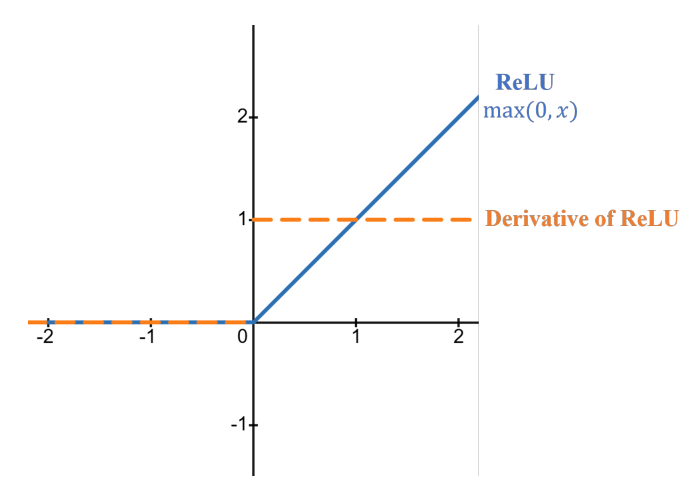

In [ ]:
################# 2. Better Activation ################

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

# 1. Thiết lập môi trường và seed
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# 2. Định nghĩa mô hình MLP với ReLU activation
class MLP_ReLU(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_ReLU, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        ################# 2. Better Activation ################
        # Khởi tạo trọng số với std nhỏ hơn cho ReLU
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    ################# 2. Better Activation ################
    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)  # Thay Sigmoid bằng ReLU
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out

# 3. Chuẩn bị dữ liệu
train_dataset = FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', train=False, download=True,
                           transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Khởi tạo model, loss và optimizer
model = MLP_ReLU(input_dims=784, hidden_dims=128, output_dims=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)

# 5. Hàm huấn luyện
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

# 6. Huấn luyện mô hình
print("Training MLP with ReLU activation...")
epochs = 100
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs)

# 7. Vẽ kết quả
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (ReLU)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (ReLU)')
plt.legend()

plt.tight_layout()
plt.show()

# 8. Đánh giá trên tập test
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = 100. * test_correct / test_total

print(f'\nTest Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

**3. Better Optimizer:** Lựa chọn cách điều chỉnh gradient linh hoạt hơn trong quá trình lan truyền ngược. Tại đây, chúng ta thay SGD bằng Adam.

In [ ]:
################# 3. Better Optimizer:  ################

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

################# 1. Environment Setup ################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    """Cố định seed cho tính reproducible"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

################# 2. Model Definition ################
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        """
        Khởi tạo MLP với 7 hidden layers
        Sử dụng khởi tạo trọng số chuẩn với std=0.05
        """
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        # Khởi tạo trọng số với std nhỏ
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        """Forward pass với Sigmoid activation"""
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)  # Giữ nguyên Sigmoid để so sánh hiệu quả của optimizer
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

################# 3. Data Loading ################
# Load và chuẩn bị dữ liệu Fashion MNIST
train_dataset = FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', train=False, download=True,
                           transform=transforms.ToTensor())

# Chia train/validation với tỉ lệ 90/10
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

################# 4. Model Setup ################
# Khởi tạo model
input_dims = 784  # 28x28 pixels
hidden_dims = 128
output_dims = 10  # 10 classes
model = MLP(input_dims=input_dims,
           hidden_dims=hidden_dims,
           output_dims=output_dims).to(device)

# Định nghĩa loss function
criterion = nn.CrossEntropyLoss()

################# 5. Better Optimizer ################
"""
Thay thế SGD bằng Adam optimizer:
- Adam tự động điều chỉnh learning rate cho từng tham số
- Sử dụng momentum và RMSprop
- Giảm thiểu ảnh hưởng của vanishing gradient
"""
lr = 1e-3  # Giảm learning rate xuống vì Adam thường cần lr nhỏ hơn SGD
optimizer = optim.Adam(model.parameters(), lr=lr)  # Thay SGD bằng Adam

################# 6. Training Function ################
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    """Huấn luyện model và theo dõi metrics"""
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()  # Adam tự động điều chỉnh learning rates

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

################# 7. Training ################
print("Training MLP with Adam optimizer...")
epochs = 100
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs)

################# 8. Visualization ################
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Adam)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (Adam)')
plt.legend()

plt.tight_layout()
plt.show()

################# 9. Evaluation ################
# Đánh giá trên tập test
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = 100. * test_correct / test_total

print(f'\nTest Results with Adam Optimizer:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

**4. Normalize Inside Network**

 Batch Normalization là một kỹ thuật phổ biến để giữ các đầu vào của từng lớp mạng trong khoảng ổn định, giúp gradient không bị triệt tiêu hoặc phóng đại. Kỹ thuật này cũng góp phần tăng tốc độ hội tụ và cải thiện khả năng tổng quát hóa của mô hình.

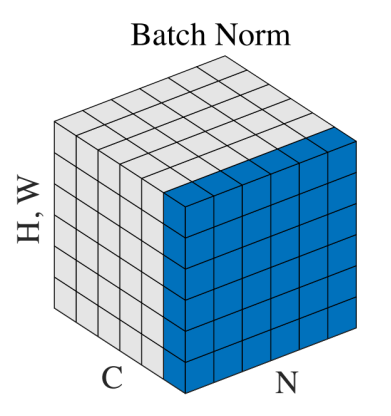

**(a) Normalize Inside Network:** Batch Normalization là một kỹ thuật phổ biến giúp chuẩn hóa đầu ra của từng lớp, giữ giá trị trong khoảng ổn định và cải thiện tốc độ hội tụ. Trong phần này, chúng ta thêm nn.BatchNorm1d() sau mỗi lớp Linear trong mạng baseline. Batch Normalization giúp giảm thiểu nguy cơ bão hòa và duy trì gradient ổn định qua các lớp.

**(b) Customized Normalization Layer**:

In [ ]:
# class MyNormalization (nn. Module ):
#     def __init__ ( self ):
#         super (). __init__ ()
#     def forward (self , x):
#         mean = torch . mean (x)
#         std = torch . std (x)
#         return (x - mean ) / std

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

################# 1. Environment Setup ################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

################# 2. Model Definitions ################
"""
a) MLP với BatchNormalization
- Thêm BatchNorm1d sau mỗi Linear layer
- Chuẩn hóa trước khi qua activation function
"""
class MLP_BatchNorm(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_BatchNorm, self).__init__()
        self.hidden_dims = hidden_dims

        # Định nghĩa activation function một lần
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

        # Định nghĩa các layers
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.bn1 = nn.BatchNorm1d(hidden_dims)  # Batch Norm sau layer 1

        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.bn2 = nn.BatchNorm1d(hidden_dims)  # Batch Norm sau layer 2

        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.bn3 = nn.BatchNorm1d(hidden_dims)  # Batch Norm sau layer 3

        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.bn4 = nn.BatchNorm1d(hidden_dims)  # Batch Norm sau layer 4

        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.bn5 = nn.BatchNorm1d(hidden_dims)  # Batch Norm sau layer 5

        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.bn6 = nn.BatchNorm1d(hidden_dims)  # Batch Norm sau layer 6

        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.bn7 = nn.BatchNorm1d(hidden_dims)  # Batch Norm sau layer 7

        self.output = nn.Linear(hidden_dims, output_dims)

        # Khởi tạo trọng số
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = nn.flatten(x)

        # Layer 1 with BatchNorm
        x = self.layer1(x)
        x = self.bn1(x)  # Normalize
        x = self.sigmoid(x)

        # Layer 2 with BatchNorm
        x = self.layer2(x)
        x = self.bn2(x)  # Normalize
        x = self.sigmoid(x)

        # Layer 3 with BatchNorm
        x = self.layer3(x)
        x = self.bn3(x)  # Normalize
        x = self.sigmoid(x)

        # Layer 4 with BatchNorm
        x = self.layer4(x)
        x = self.bn4(x)  # Normalize
        x = self.sigmoid(x)

        # Layer 5 with BatchNorm
        x = self.layer5(x)
        x = self.bn5(x)  # Normalize
        x = self.sigmoid(x)

        # Layer 6 with BatchNorm
        x = self.layer6(x)
        x = self.bn6(x)  # Normalize
        x = self.sigmoid(x)

        # Layer 7 with BatchNorm
        x = self.layer7(x)
        x = self.bn7(x)  # Normalize
        x = self.sigmoid(x)

        out = self.output(x)
        return out

"""
b) Custom Normalization Layer
- Chuẩn hóa dựa trên mean và std của toàn bộ batch
- Đơn giản hơn BatchNorm (không có learnable parameters)
"""
class MyNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / (std + 1e-8)  # Thêm epsilon để tránh chia cho 0

class MLP_CustomNorm(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_CustomNorm, self).__init__()

        # Định nghĩa activation function một lần
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

        # Định nghĩa các layers
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.norm1 = MyNormalization()  # Custom norm sau layer 1

        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.norm2 = MyNormalization()  # Custom norm sau layer 2

        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.norm3 = MyNormalization()  # Custom norm sau layer 3

        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.norm4 = MyNormalization()  # Custom norm sau layer 4

        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.norm5 = MyNormalization()  # Custom norm sau layer 5

        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.norm6 = MyNormalization()  # Custom norm sau layer 6

        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.norm7 = MyNormalization()  # Custom norm sau layer 7

        self.output = nn.Linear(hidden_dims, output_dims)

        # Khởi tạo trọng số
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = nn.flatten(x)

        x = self.layer1(x)
        x = self.norm1(x)  # Custom normalize
        x = nn.sigmoid(x)

        x = self.layer2(x)
        x = self.norm2(x)  # Custom normalize
        x = nn.sigmoid(x)

        x = self.layer3(x)
        x = self.norm3(x)  # Custom normalize
        x = nn.sigmoid(x)

        x = self.layer4(x)
        x = self.norm4(x)  # Custom normalize
        x = nn.sigmoid(x)

        x = self.layer5(x)
        x = self.norm5(x)  # Custom normalize
        x = nn.sigmoid(x)

        x = self.layer6(x)
        x = self.norm6(x)  # Custom normalize
        x = nn.sigmoid(x)

        x = self.layer7(x)
        x = self.norm7(x)  # Custom normalize
        x = nn.sigmoid(x)

        out = self.output(x)
        return out

################# 3. Training Functions ################
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, model_name):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'[{model_name}] Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

################# 4. Training Both Models ################
# Chuẩn bị dữ liệu
train_dataset = FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', train=False, download=True,
                           transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Hyperparameters
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-3
epochs = 100

# Train BatchNorm model
print("\nTraining BatchNorm Model...")
model_bn = MLP_BatchNorm(input_dims, hidden_dims, output_dims).to(device)
criterion_bn = nn.CrossEntropyLoss()
optimizer_bn = optim.Adam(model_bn.parameters(), lr=lr)
results_bn = train_model(model_bn, train_loader, val_loader, criterion_bn,
                        optimizer_bn, epochs, "BatchNorm")

# Train Custom Norm model
print("\nTraining Custom Norm Model...")
model_custom = MLP_CustomNorm(input_dims, hidden_dims, output_dims).to(device)
criterion_custom = nn.CrossEntropyLoss()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=lr)
results_custom = train_model(model_custom, train_loader, val_loader, criterion_custom,
                           optimizer_custom, epochs, "CustomNorm")

################# 5. Visualization ################
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(results_bn[0], label='BatchNorm Train Loss')
plt.plot(results_bn[2], label='BatchNorm Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BatchNorm Model - Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(results_custom[0], label='CustomNorm Train Loss')
plt.plot(results_custom[2], label='CustomNorm Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CustomNorm Model - Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 3)
plt.plot(results_bn[1], label='BatchNorm Train Acc')
plt.plot(results_bn[3], label='BatchNorm Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('BatchNorm Model - Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(results_custom[1], label='CustomNorm Train Acc')
plt.plot(results_custom[3], label='CustomNorm Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('CustomNorm Model - Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

################# 6. Evaluation ################
def evaluate_model(model, test_loader, criterion, model_name):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_acc = 100. * test_correct / test_total

    print(f'\nTest Results for {model_name}:')
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.2f}%')

# Evaluate both models
evaluate_model(model_bn, test_loader, criterion_bn, "BatchNorm")
evaluate_model(model_custom, test_loader, criterion_custom, "CustomNorm")

**5. Skip Connection:** Được giới thiệu trong kiến trúc của mạng ResNet, giúp gradient có thể lan truyền trực tiếp qua các lớp mà không bị triệt tiêu. Điều này không chỉ cải thiện khả năng hội tụ mà còn giữ được thông tin từ các tầng trước đó.

Tại đây, chúng ta triển khai skip connections bằng cách cộng đầu ra của các lớp trước (skip connections) với các lớp tiếp theo tại một số điểm trong mạng.

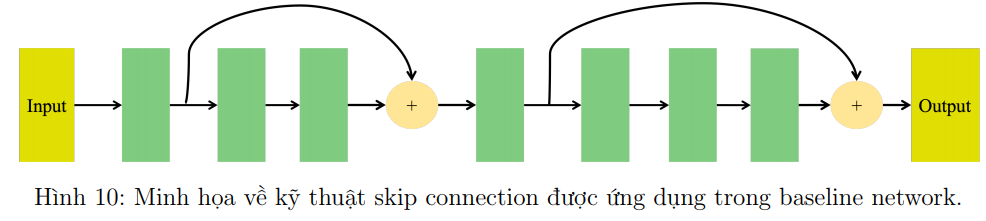

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

################# 1. Environment Setup ################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

################# 2. MLP with Skip Connections ################
class MLP_SkipConnection(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP_SkipConnection, self).__init__()

        # Định nghĩa activation functions
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

        # Định nghĩa các layers
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        # Khởi tạo trọng số
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        """
        Forward pass với skip connections:
        - Skip connection sau layer 1 đến layer 3
        - Skip connection sau layer 4 đến layer 7
        """
        x = self.flatten(x)

        # First block
        x = self.layer1(x)
        x = self.sigmoid(x)
        skip1 = x  # Lưu skip connection đầu tiên

        x = self.layer2(x)
        x = self.sigmoid(x)

        x = self.layer3(x)
        x = self.sigmoid(x)
        x = x + skip1  # Thêm skip connection

        # Second block
        x = self.layer4(x)
        x = self.sigmoid(x)
        skip2 = x  # Lưu skip connection thứ hai

        x = self.layer5(x)
        x = self.sigmoid(x)

        x = self.layer6(x)
        x = self.sigmoid(x)

        x = self.layer7(x)
        x = self.sigmoid(x)
        x = x + skip2  # Thêm skip connection

        out = self.output(x)
        return out

################# 3. Load và chuẩn bị dữ liệu ################
train_dataset = FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', train=False, download=True,
                           transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

################# 4. Training Function ################
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

################# 5. Model Training ################
# Khởi tạo model
input_dims = 784
hidden_dims = 128
output_dims = 10
model = MLP_SkipConnection(input_dims, hidden_dims, output_dims).to(device)

# Định nghĩa loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training
print("\nTraining MLP with Skip Connections...")
epochs = 100
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs)

################# 6. Visualization ################
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (Skip Connections)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy (Skip Connections)')
plt.legend()

plt.tight_layout()
plt.show()

################# 7. Evaluation ################
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = 100. * test_correct / test_total

print(f'\nTest Results with Skip Connections:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

**6. Train layers separately (fine-tuning)**: Trong các mạng rất sâu, việc huấn luyện toàn bộ các lớp có thể dẫn đến hiệu suất thấp do vấn đề Vanishing Gradient.

Bằng cách chỉ huấn luyện một số lớp cụ thể, mô hình có thể tập trung vào việc học các đặc trưng quan trọng hơn mà không bị ảnh hưởng bởi các lớp sâu hơn.

Kỹ thuật này được triển khai bằng cách xây dựng các mô hình nhỏ hơn tương ứng với từng số lượng lớp cần huấn luyện, sau đó tăng dần các lớp được tham gia huấn luyện.

 a) Giai đoạn 1 - Huấn luyện chỉ với thành phần đầu tiên: Ở bước đầu tiên, chỉ
thành phần first tham gia vào quá trình huấn luyện. Thành phần này được nối với
một lớp đầu ra để thực hiện dự đoán, trong khi các thành phần khác chưa được thêm vào.

b) Giai đoạn 2 - Thêm thành phần thứ hai: Sau khi huấn luyện xong first, chúng
ta thêm thành phần second vào mạng. Thành phần first được giữ cố định (không  cập nhật trọng số), và chỉ second được tham gia vào quá trình huấn luyện.

c)  Giai đoạn 3 - Thêm thành phần thứ ba: Tiếp theo, thành phần third được
thêm vào mạng. Tương tự, first và second vẫn giữ cố định, chỉ third tham gia
huấn luyện.

d) Giai đoạn 4 - Mở khóa toàn bộ thành phần: Cuối cùng, sau khi thêm đủ các
thành phần, chúng ta mở khóa tất cả các lớp trong mạng và thực hiện huấn luyện
toàn bộ mô hình. Điều này đảm bảo rằng tất cả các lớp đều được tối ưu hóa chung
để đạt hiệu suất tốt nhất.

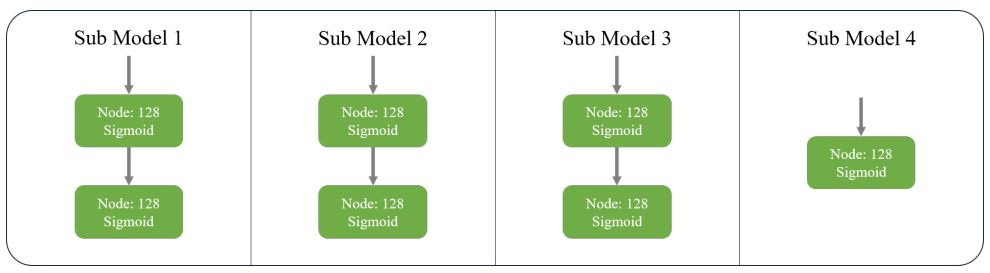

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

################# 1. Environment Setup ################
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

################# 2. Model Components ################
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        # Định nghĩa activations
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

        # Layer
        self.layer1 = nn.Linear(input_dims, output_dims)

        # Khởi tạo trọng số
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        return x

class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        # Định nghĩa activations
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

        # Layers
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        # Khởi tạo trọng số
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.sigmoid(x)
        return x

################# 3. Training Function ################
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, phase):
    """
    Hàm huấn luyện mô hình với monitoring
    """
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Phase {phase} - Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

################# 4. Layer-wise Training ################
def train_layerwise(train_loader, val_loader, epochs=20):
    """
    Huấn luyện từng layer theo thứ tự
    """
    results = {}
    lr = 1e-2
    criterion = nn.CrossEntropyLoss()

    # Phase 1: Train first component
    print("\nPhase 1: Training first component...")
    first = MLP_2layers(input_dims=784, output_dims=128).to(device)
    model = nn.Sequential(
        first,
        nn.Linear(128, 10)
    ).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    results['phase1'] = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, 'Phase 1')

    # Phase 2: Add and train second component
    print("\nPhase 2: Training second component...")
    for param in first.parameters():
        param.requires_grad = False
    second = MLP_2layers(input_dims=128, output_dims=128).to(device)
    model = nn.Sequential(
        first,
        second,
        nn.Linear(128, 10)
    ).to(device)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    results['phase2'] = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, 'Phase 2')

    # Phase 3: Add and train third component
    print("\nPhase 3: Training third component...")
    for param in second.parameters():
        param.requires_grad = False
    third = MLP_2layers(input_dims=128, output_dims=128).to(device)
    model = nn.Sequential(
        first,
        second,
        third,
        nn.Linear(128, 10)
    ).to(device)
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    results['phase3'] = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, 'Phase 3')

    # Phase 4: Add fourth component and train all layers
    print("\nPhase 4: Fine-tuning all components...")
    for param in first.parameters():
        param.requires_grad = True
    for param in second.parameters():
        param.requires_grad = True
    for param in third.parameters():
        param.requires_grad = True
    fourth = MLP_1layer(input_dims=128, output_dims=128).to(device)
    model = nn.Sequential(
        first,
        second,
        third,
        fourth,
        nn.Linear(128, 10)
    ).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr/10)  # Giảm learning rate cho fine-tuning
    results['phase4'] = train_model(model, train_loader, val_loader, criterion, optimizer, epochs, 'Phase 4')

    return model, results

################# 5. Data Loading ################
train_dataset = FashionMNIST('./data', train=True, download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data', train=False, download=True,
                           transform=transforms.ToTensor())

train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

################# 6. Training and Visualization ################
# Train model layer-wise
final_model, training_results = train_layerwise(train_loader, val_loader, epochs=20)

# Visualize results
plt.figure(figsize=(20, 10))

# Plot Loss
plt.subplot(2, 2, 1)
for phase in ['phase1', 'phase2', 'phase3', 'phase4']:
    plt.plot(training_results[phase][0], label=f'{phase} Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Phases')
plt.legend()

plt.subplot(2, 2, 2)
for phase in ['phase1', 'phase2', 'phase3', 'phase4']:
    plt.plot(training_results[phase][2], label=f'{phase} Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Across Phases')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 3)
for phase in ['phase1', 'phase2', 'phase3', 'phase4']:
    plt.plot(training_results[phase][1], label=f'{phase} Train Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Across Phases')
plt.legend()

plt.subplot(2, 2, 4)
for phase in ['phase1', 'phase2', 'phase3', 'phase4']:
    plt.plot(training_results[phase][3], label=f'{phase} Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Across Phases')
plt.legend()

plt.tight_layout()
plt.show()

################# 7. Evaluation ################
final_model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = final_model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_total += targets.size(0)
        test_correct += predicted.eq(targets).sum().item()

test_loss = test_loss / len(test_loader)
test_acc = 100. * test_correct / test_total

print(f'\nFinal Test Results:')
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2f}%')

**7. Gradient Normalization:** Là một kỹ thuật với ý tưởng chuẩn hóa gradient trong quá trình lan truyền ngược.

Kỹ thuật này đảm bảo gradient được duy trì trong một phạm vi hợp lý, tránh việc chúng trở nên quá nhỏ hoặc quá lớn, từ đó giúp cải thiện quá trình học của các
lớp sâu hơn trong mạng.

Tại đây, chúng ta cài đặt một lớp GradientNormalizationLayer, sử dụng cơ chế autograd của PyTorch để chuẩn hóa gradient trong giai đoạn lan truyền ngược. Cụ thể, gradient được điều chỉnh bằng cách chuẩn hóa theo trung bình và độ lệch
chuẩn của chúng, đảm bảo các giá trị gradient không bị triệt tiêu hoặc phóng đại.

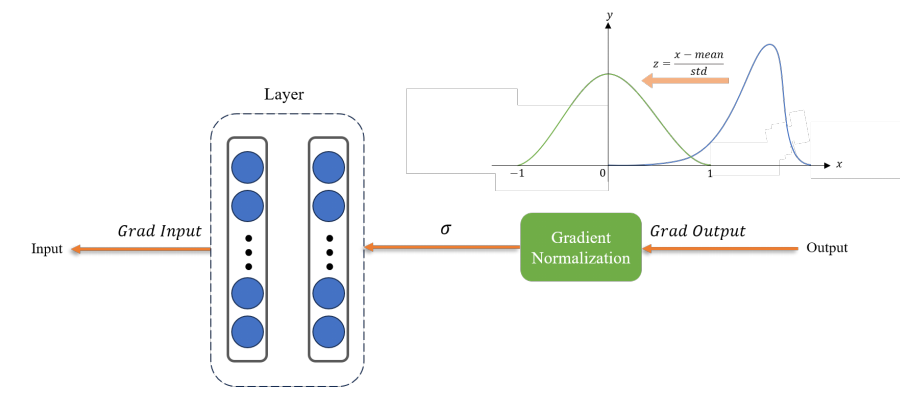

Epoch [1/100] Train Loss: 2.3063, Train Acc: 10.08%, Val Loss: 2.3084, Val Acc: 8.95%
Epoch [2/100] Train Loss: 2.3050, Train Acc: 9.91%, Val Loss: 2.3052, Val Acc: 10.20%
Epoch [3/100] Train Loss: 2.3053, Train Acc: 9.78%, Val Loss: 2.3056, Val Acc: 10.00%
Epoch [4/100] Train Loss: 2.3050, Train Acc: 10.21%, Val Loss: 2.3042, Val Acc: 10.22%
Epoch [5/100] Train Loss: 2.3051, Train Acc: 10.02%, Val Loss: 2.3061, Val Acc: 10.12%
Epoch [6/100] Train Loss: 2.3053, Train Acc: 9.86%, Val Loss: 2.3062, Val Acc: 9.97%
Epoch [7/100] Train Loss: 2.3051, Train Acc: 9.99%, Val Loss: 2.3037, Val Acc: 9.97%
Epoch [8/100] Train Loss: 2.3048, Train Acc: 9.97%, Val Loss: 2.3048, Val Acc: 10.18%
Epoch [9/100] Train Loss: 2.3051, Train Acc: 9.82%, Val Loss: 2.3041, Val Acc: 10.20%
Epoch [10/100] Train Loss: 2.3045, Train Acc: 10.11%, Val Loss: 2.3040, Val Acc: 10.97%
Epoch [11/100] Train Loss: 2.3051, Train Acc: 9.92%, Val Loss: 2.3064, Val Acc: 10.20%
Epoch [12/100] Train Loss: 2.3049, Train Acc: 10.04

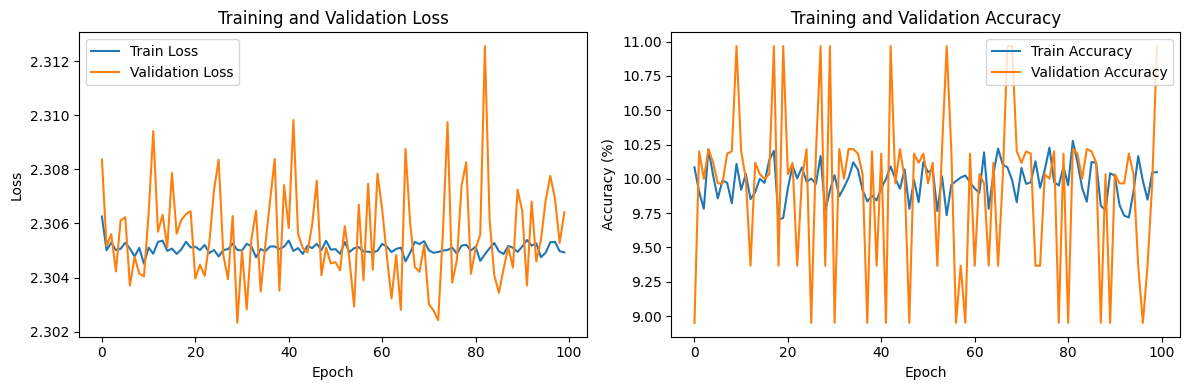

In [3]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

# 1. Thiết lập môi trường và seed
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

# 2. Tải và chuẩn bị dữ liệu
train_dataset = FashionMNIST('./data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

# 3. Chia tập train/validation
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# 4. Tạo DataLoader
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Định nghĩa lớp Gradient Normalization
class GradientNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Forward pass: pass input unchanged
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        # Normalize the gradient
        mean = torch.mean(grad_output)
        std = torch.std(grad_output)
        grad_input = (grad_output - mean) / (std + 1e-6)  # Avoid division by zero
        return grad_input

# Wrapper Module for GradientNormalization
class GradientNormalizationLayer(nn.Module):
    def __init__(self):
        super(GradientNormalizationLayer, self).__init__()

    def forward(self, x):
        return GradientNormalization.apply(x)

# 6. Định nghĩa mô hình MLP
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        # Định nghĩa hàm kích hoạt
        self.sigmoid = nn.Sigmoid()
        self.flatten = nn.Flatten()

        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.gn1 = GradientNormalizationLayer()
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.gn2 = GradientNormalizationLayer()
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.gn3 = GradientNormalizationLayer()
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.gn4 = GradientNormalizationLayer()
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.gn5 = GradientNormalizationLayer()
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.gn6 = GradientNormalizationLayer()
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.gn7 = GradientNormalizationLayer()
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.gn1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        x = self.gn2(x)
        x = self.sigmoid(x)
        x = self.layer3(x)
        x = self.gn3(x)
        x = self.sigmoid(x)
        x = self.layer4(x)
        x = self.gn4(x)
        x = self.sigmoid(x)
        x = self.layer5(x)
        x = self.gn5(x)
        x = self.sigmoid(x)
        x = self.layer6(x)
        x = self.gn6(x)
        x = self.sigmoid(x)
        x = self.layer7(x)
        x = self.gn7(x)
        x = self.sigmoid(x)
        out = self.output(x)
        return out

# 7. Khởi tạo mô hình và định nghĩa loss, optimizer
input_dims = 784  # 28x28 pixels
hidden_dims = 128
output_dims = 10  # 10 classes
lr = 1e-2

model = MLP(input_dims=input_dims,
           hidden_dims=hidden_dims,
           output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 8. Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        train_loss = train_loss / len(train_loader)
        train_acc = 100. * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, train_accs, val_losses, val_accs

# 9. Huấn luyện mô hình
epochs = 100
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, epochs)

# 10. Vẽ đồ thị kết quả
def plot_results(train_losses, val_losses, train_accs, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Training and Validation Loss')

    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()

plot_results(train_losses, val_losses, train_accs, val_accs)


<!-- Tự xây dựng một class layer normalization -------
class MyNormalization (nn. Module ):
    def __init__ ( self ):
        super (). __init__ ()
    def forward (self , x):
        mean = torch . mean (x)
        std = torch . std (x)
        return (x - mean ) / std
-->